# Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


Working with CUDA capabilities.

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
GeForce RTX 2080 with Max-Q Design


# Loading the train data set

In [3]:
data_dir = '../../Images/june5Night/Positive/'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

We see 20 batches of 15 images each. Becasue we have in total 295 of positive images.

In [5]:
print(len(dataloader))

20


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.) tensor(1.)


# Showing one sample of the training set images

Grabbing only one image of the training set, permuting its shape sizes and converting to numpy to able to display it.

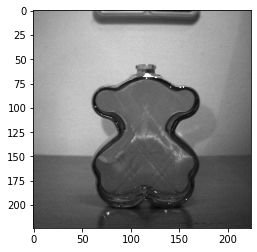

In [7]:
single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().numpy()

plt.imshow(single_img_numpy)

Now, cropping the image to be of size 160x160.

In [8]:
TOP_CROP_POS = 50
LEFT_CROP_POS = 35

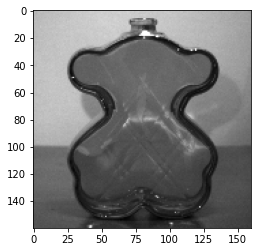

In [9]:

imgs_croped = transforms.functional.crop(images, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
single_img = imgs_croped[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

# Building the model Autoencoder model

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # 15, 3, 160, 160.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 55           # ~= 110/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        output_channels_layer2 = output_channels*2+5
        output_channels_layer3 = output_channels_layer2*2

        self.conv2d_1 = nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_2 = nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_3 = nn.Conv2d(output_channels_layer2, output_channels_layer3, 5)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        # self.fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        # self.encoder_tanh = nn.Tanh()
        # self.decoder_tanh = nn.Tanh()
        # self.decoder_fc = nn.Linear(output_channels_layer3, output_channels_layer3)

        self.convTranspose2d_1 = nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 5)
        self.convTranspose2d_2 = nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=4)
        self.convTranspose2d_3 = nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=3)
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            output = x
            print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            print("self.conv2d_3 shape is: ", output.shape)
            
            # output = output.view(output.size(0), -1)
            # print("output.view shape is: ", output.shape)

            # print("The LINEAR and TANH layers")
            # output = output.view(output.size(0), -1)
            # print("output.view shape is: ", output.shape)
            # output = self.fc(output)
            # print("self.fc shape is: ", output.shape)
            # output = self.encoder_tanh(output)
            # print("self.encoder_tanh shape is: ", output.shape)

            # output = self.decoder_tanh(output)
            # print("self.decoder_tanh shape is: ", output.shape)
            # output = self.decoder_fc(output)
            # print("self.decoder_fc shape is: ", output.shape)
            # output = output.view(-1, output.size(1), 1, 1)
            # print("output.view shape is: ", output.shape)
            

            print("The DECODER part is executing")
            output = self.convTranspose2d_1(output)
            print("self.convTranspose2d_1 shape is: ", output.shape)
            output = self.relu3(output)
            output = self.convTranspose2d_2(output)
            print("self.convTranspose2d_2 shape is: ", output.shape)
            output = self.relu4(output)
            output = self.convTranspose2d_3(output)
            print("self.convTranspose2d_3 shape is: ", output.shape)
            output = self.sigmoid(output)
            print("self.sigmoid shape is: ", output.shape)

            print("Finish the FORWARD function")
        else:
            # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            output = x
            # print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            # print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            # print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            # print("self.conv2d_3 shape is: ", output.shape)

            # # print("The LINEAR and TANH layers")
            # output = output.view(output.size(0), -1)
            # # print("output.view shape is: ", output.shape)
            # output = self.fc(output)
            # # print("self.fc shape is: ", output.shape)
            # output = self.encoder_tanh(output)
            # # print("self.encoder_tanh shape is: ", output.shape)

            # output = self.decoder_tanh(output)
            # # print("self.decoder_tanh shape is: ", output.shape)
            # output = self.decoder_fc(output)
            # # print("self.decoder_fc shape is: ", output.shape)
            # output = output.view(-1, output.size(1), 1, 1)
            # # print("output.view shape is: ", output.shape)
            

            # print("The DECODER part is executing")
            output = self.convTranspose2d_1(output)
            # print("self.convTranspose2d_1 shape is: ", output.shape)
            output = self.relu3(output)
            output = self.convTranspose2d_2(output)
            # print("self.convTranspose2d_2 shape is: ", output.shape)
            output = self.relu4(output)
            output = self.convTranspose2d_3(output)
            # print("self.convTranspose2d_3 shape is: ", output.shape)
            output = self.sigmoid(output)
            # print("self.sigmoid shape is: ", output.shape)

            # print("Finish the FORWARD function")
        return output
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [11]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


In [12]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, 
                             weight_decay=1e-5)
model.to(device)

Autoencoder(
  (conv2d_1): Conv2d(3, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_2): Conv2d(55, 115, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_3): Conv2d(115, 230, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (relu2): ReLU()
  (convTranspose2d_1): ConvTranspose2d(230, 115, kernel_size=(5, 5), stride=(1, 1))
  (convTranspose2d_2): ConvTranspose2d(115, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(4, 4))
  (convTranspose2d_3): ConvTranspose2d(55, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(3, 3))
  (relu3): ReLU()
  (relu4): ReLU()
  (sigmoid): Sigmoid()
)

In [13]:
num_epochs = 1
outputs = []
for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader):
        if i == 1:
            break
        img = img.to(device)
        imgs_croped = transforms.functional.crop(img.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
        single_img = imgs_croped[0]
        image_in_tensor = single_img[None, :].cuda()
        print(image_in_tensor.shape)
        # Forward pass
        recon = model(image_in_tensor,True)          # The entire batch of images is passed to the model
        loss = criterion(recon, image_in_tensor)

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

torch.Size([1, 3, 160, 160])
The FORWARD function is starting
The ENCODER part is executing
The input image shape is:  torch.Size([1, 3, 160, 160])
self.conv2d_1 shape is:  torch.Size([1, 55, 31, 31])
self.conv2d_2 shape is:  torch.Size([1, 115, 5, 5])
self.conv2d_3 shape is:  torch.Size([1, 230, 1, 1])
The DECODER part is executing
self.convTranspose2d_1 shape is:  torch.Size([1, 115, 5, 5])
self.convTranspose2d_2 shape is:  torch.Size([1, 55, 31, 31])
self.convTranspose2d_3 shape is:  torch.Size([1, 3, 160, 160])
self.sigmoid shape is:  torch.Size([1, 3, 160, 160])
Finish the FORWARD function
Epoch:1, Loss:0.0481


In [14]:
torch.cuda.empty_cache()

# Training the model

In [15]:
val_dir_for_training = '../../Images/june5Night/Positive_val'      #This is for the home laptop

transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_val_for_training = datasets.ImageFolder(val_dir_for_training, transform=transform_characteristics)
dataloader_val_for_training = torch.utils.data.DataLoader(dataset_val_for_training, batch_size=15, shuffle=True)
print(len(dataloader_val_for_training))

2


In [16]:
# get the layers as a list
model_children = list(model.children())
print(model_children)

[Conv2d(3, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1)), Conv2d(55, 115, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1)), Conv2d(115, 230, kernel_size=(5, 5), stride=(1, 1)), ReLU(), ReLU(), ConvTranspose2d(230, 115, kernel_size=(5, 5), stride=(1, 1)), ConvTranspose2d(115, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(4, 4)), ConvTranspose2d(55, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(3, 3)), ReLU(), ReLU(), Sigmoid()]


In [17]:
# define the sparse loss function
def compute_l2_loss(autoencoder, images):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        loss += torch.mean(torch.square(values))
    return loss

In [18]:
reg_param = 0.001 # regularization parameter `lambda`

Actually training the model with early stopping on the validation loss values and storing the loss function values accross all epochs.

In [19]:
# epochs_toCheck_earlyStopping = 10
# min_diff_earlyStopping = 0.0005
epochs_toCheck_earlyStopping = 20
min_diff_earlyStopping = 0.00001

# Point to training loop video
num_epochs = 300
outputs = []
prev_losses = [float('inf')] * epochs_toCheck_earlyStopping  # Initialize previous losses with infinity
losses_list = []
losses_avg_list = []

losses_val_list = []
losses_val_avg_list = []

for epoch in range(num_epochs):
    for (img, _) in dataloader:     # This iterates over the batches of images.
        img = img.to(device)
        imgs_croped = transforms.functional.crop(img, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

        # Forward pass
        recon = model(imgs_croped.cuda())          # The entire batch of images is passed to the model
        loss = criterion(recon, imgs_croped)

        l2_loss = compute_l2_loss(model, img)
        # add the sparsity penalty
        loss = loss + reg_param * l2_loss

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 
        losses_list.append(loss.item())  

    for (img, _) in dataloader_val_for_training:     # This iterates over the batches of images.
        img = img.to(device)
        imgs_croped = transforms.functional.crop(img, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

        # Forward pass
        recon_val = model(imgs_croped.cuda())          # The entire batch of images is passed to the model
        losses_val = criterion(recon_val, imgs_croped)
        losses_val_list.append(losses_val.item())

    loss_avg_epoch = np.mean(losses_list[-len(dataloader):])
    losses_avg_list.append(loss_avg_epoch)
    
    loss_val_avg_epoch = np.mean(losses_val_list[-len(dataloader_val_for_training):])
    losses_val_avg_list.append(loss_val_avg_epoch)

    print(f'Epoch:{epoch+1}, average training loss:{loss_avg_epoch:.4f}, average validation loss:{loss_val_avg_epoch:.4f}')

    # Append the current validation loss to the previous losses list
    prev_losses.append(loss_val_avg_epoch)
    prev_losses = prev_losses[-epochs_toCheck_earlyStopping:]  # Keep only the last 10 losses
    # print(prev_losses)
    # Check if the last 10 losses are the same (within a tolerance)
    stop_training = all(abs(loss_val_avg_epoch - prev_loss) < min_diff_earlyStopping for prev_loss in prev_losses)

    # Break the training loop if the stopping condition is met
    if stop_training:
        print('Early stopping triggered. Training stopped.')
        break

# open file
with open('losseslistTrain_v8.txt', 'w+') as g:
    # write elements of list
    for items in losses_list:
        g.write('%s\n' %items)
    print("losseslistTrain written successfully")
# close the file
g.close() 

# open file
with open('losseslist_avg_Train_v8.txt', 'w+') as g:
    # write elements of list
    for items in losses_avg_list:
        g.write('%s\n' %items)
    print("losseslist_avg_Train written successfully")
# close the file
g.close()

# open file
with open('losseslistVal_v8.txt', 'w+') as g:
    # write elements of list
    for items in losses_val_list:
        g.write('%s\n' %items)
    print("losseslistVal written successfully")
# close the file
g.close() 

# open file
with open('losses_avg_Val_v8.txt', 'w+') as g:
    # write elements of list
    for items in losses_val_avg_list:
        g.write('%s\n' %items)
    print("losseslist_avg_Val written successfully")
# close the file
g.close()

Epoch:1, average training loss:0.0485, average validation loss:0.0471
Epoch:2, average training loss:0.0483, average validation loss:0.0474
Epoch:3, average training loss:0.0463, average validation loss:0.0365
Epoch:4, average training loss:0.0360, average validation loss:0.0302
Epoch:5, average training loss:0.0291, average validation loss:0.0224
Epoch:6, average training loss:0.0209, average validation loss:0.0190
Epoch:7, average training loss:0.0174, average validation loss:0.0167
Epoch:8, average training loss:0.0158, average validation loss:0.0161
Epoch:9, average training loss:0.0151, average validation loss:0.0155
Epoch:10, average training loss:0.0146, average validation loss:0.0160
Epoch:11, average training loss:0.0142, average validation loss:0.0151
Epoch:12, average training loss:0.0140, average validation loss:0.0149
Epoch:13, average training loss:0.0138, average validation loss:0.0143
Epoch:14, average training loss:0.0137, average validation loss:0.0158
Epoch:15, avera

In [20]:
filepath = "models/PytorchCUDA_AutoencoderDS2_croppingImages_V9"

Saving the model

In [21]:
torch.save(model.state_dict(), filepath)

Loading the model

In [ ]:
# # For loading the model 
# model.load_state_dict(torch.load(filepath))                                         # For home laptop
# # model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))     # For work laptop
# model.eval()

The evolution of the training loss function accross all epochs.

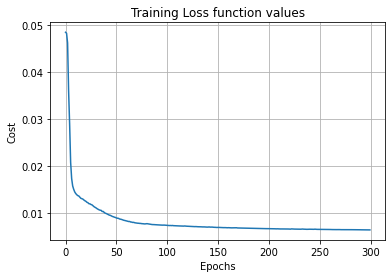

In [22]:
# Load data from the text file
with open("losseslist_avg_Train_v8.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Training Loss function values")
plt.grid(True)
plt.show()

The evolution of the validation loss function accross all epochs.

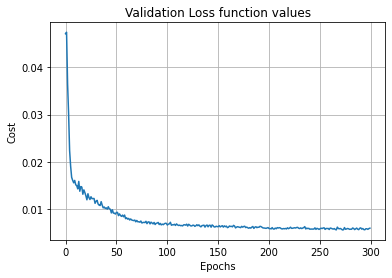

In [23]:
# Load data from the text file
with open("losses_avg_Val_V8.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Validation Loss function values")
plt.grid(True)
plt.show()

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [24]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

# Quantifying the reconstruction error

Performing the computation of the reconstruction error of all the images in the training dataset. Computing the MSE of each image with its reconstructed version.

In [25]:
def mse(image1, image2):
    image_permuted1 = image1.permute(1, 2, 0) 
    img_numpy1 = image_permuted1.detach().cpu().numpy()

    image_permuted2 = image2.permute(1, 2, 0) 
    img_numpy2 = image_permuted2.detach().cpu().numpy()

    squared_diff = np.square(img_numpy1 - img_numpy2)
    mse_value = np.mean(squared_diff)
    return mse_value

In [26]:
result_lst = []

for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    imgs_croped = transforms.functional.crop(image_in_tensor.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
    image_in_tensor = imgs_croped[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = mse(image_in_tensor[0], Y[0])
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.005105952), (1, 0.005097825), (2, 0.004999263), (3, 0.0049833967), (4, 0.0049876086), (5, 0.0051156133), (6, 0.0051798075), (7, 0.0052453415), (8, 0.005298438), (9, 0.004924943), (10, 0.0049833176), (11, 0.0050482345), (12, 0.005375708), (13, 0.0054887505), (14, 0.005366204), (15, 0.005194332), (16, 0.0059221396), (17, 0.0058625825), (18, 0.005811628), (19, 0.0056882934), (20, 0.005720587), (21, 0.006006916), (22, 0.0060626487), (23, 0.00604949), (24, 0.0049664364), (25, 0.0050306097), (26, 0.005141974), (27, 0.005820641), (28, 0.006304611), (29, 0.0062010027), (30, 0.0062630107), (31, 0.0062331324), (32, 0.0053404775), (33, 0.0051301992), (34, 0.005381144), (35, 0.005504943), (36, 0.00526798), (37, 0.004948959), (38, 0.00545272), (39, 0.0062543815), (40, 0.006369303), (41, 0.005617849), (42, 0.005565452), (43, 0.0056548575), (44, 0.0056618513), (45, 0.005114356), (46, 0.0050650258), (47, 0.004993902), (48, 0.0050409166), (49, 0.0060318), (50, 0.0059297984), (51, 0.005630861), (

In [27]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(117, 0.009396966), (167, 0.009186236), (168, 0.009105018), (166, 0.009083982), (165, 0.008891293), (154, 0.008792949), (157, 0.0087399315), (126, 0.008680512), (155, 0.008634849), (156, 0.008625325), (125, 0.008614372), (158, 0.008412572), (127, 0.008409866), (118, 0.008394525), (176, 0.008241734), (121, 0.008213215), (119, 0.008202764), (110, 0.008192132), (160, 0.008183032), (122, 0.008173821), (109, 0.008151083), (120, 0.008124808), (159, 0.008101873), (169, 0.008100005), (139, 0.008096015), (170, 0.008082178), (111, 0.008043521), (99, 0.008017617), (107, 0.008003133), (112, 0.007950757), (108, 0.007896139), (189, 0.007760914), (267, 0.0077374172), (128, 0.00772727), (188, 0.007720485), (93, 0.007678203), (175, 0.0076171), (187, 0.0075691105), (284, 0.00755529), (220, 0.0075014737), (100, 0.007496937), (183, 0.0074807317), (184, 0.0074802143), (138, 0.0074557685), (102, 0.0074497596), (192, 0.0074264915), (211, 0.007421878), (101, 0.0073994603), (193, 0.007396258), (164, 0.0073954

Gaphically the distribution of the reconstruction error values is shown below:

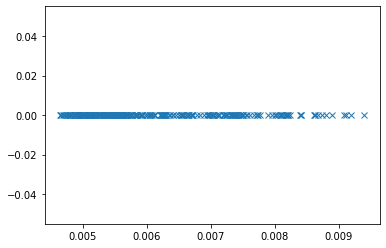

In [28]:
errors_list = []
for i in range(len(result_lst)):
    errors_list.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

In [29]:
na_avg_rcn_error = np.mean(np.array(errors_list))  
na_stdev_rcn_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_avg_rcn_error)
print("The standard deviation of the errors list is: ", na_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.0061501176
The standard deviation of the errors list is:  0.0011380187
The min value of the errors list is:  0.004643138
The max value of the errors list is:  0.009396966


Or displying in a histogram way:

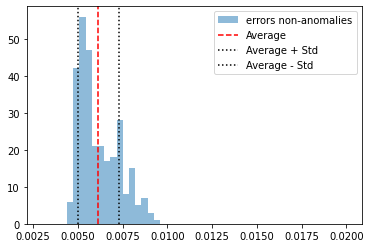

In [32]:
bins = np.linspace(0.003, 0.02, 50)
plt.hist(errors_list, bins, alpha=0.5, label='errors non-anomalies')
plt.legend(loc='upper right')

# Calculate average and standard deviation
average = np.mean(errors_list)
std = np.std(errors_list)

# Plot average line
plt.axvline(x=average, color='red', linestyle='--', label='Average')

# Plot lines for standard deviation
plt.axvline(x=average + std, color='black', linestyle=':', label='Average + Std')
plt.axvline(x=average - std, color='black', linestyle=':', label='Average - Std')

plt.legend()

plt.show()

# Function to check if an image contains anomalies

Based on the previously found histogram, its average and its standard deviation values, it can be built a function that maps the reconstruction error to a probability value of an image being considered as an anomaly or not.

If the a given reconstruction value is outside the range of the standard deviation sum and subtraction to the average values, shown in the plot above, then that reconstruction error has more than 50% chance to be considered as an anomaly image.

In [33]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [34]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

Testing a reconstruction error. Verifying that given some reconstruction error, the probability value is the one we expect. 

In [35]:
print(map_error2prob(na_avg_rcn_error + na_stdev_rcn_error))

50.0000102296495


In [36]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

# Validating the performance of the model with reconstruction error directly

We will use the validation data set to find the best threshold value for predicting an image as anomaly or non-anomaly.

In [37]:
val_dir = '../../Images/june5Night/Validation'      #This is for the home laptop
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
# test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the work laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_val = datasets.ImageFolder(val_dir, transform=transform_characteristics)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=15, shuffle=True)
classes = ('non-anomaly','anomaly')

In [38]:
y_true = []
recError_lst = []

for i in range(len(dataset_val)):
    X = dataset_val[i]
    image_in_tensor = X[0]
    imgs_croped = transforms.functional.crop(image_in_tensor.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
    image_in_tensor = imgs_croped[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = mse(image_in_tensor[0], Y[0])
    recError_lst.append(err)     # idx of data item, err
    y_true.append(ground_truth) # Save Truth
print("The reconstruction error list is: ", recError_lst)
print("The ground truth labels are: ", y_true)

The reconstruction error list is:  [0.0054540043, 0.0051928544, 0.0052415985, 0.006146998, 0.0056157447, 0.0055047804, 0.0051139686, 0.0053829807, 0.005439637, 0.0062847403, 0.005337342, 0.0053566215, 0.004954566, 0.005326202, 0.0064285016, 0.0055030007, 0.0059891185, 0.004775985, 0.004795975, 0.007421121, 0.0064597493, 0.006584819, 0.016778978, 0.0062680147, 0.006318023, 0.011907903, 0.008827429, 0.0065358113, 0.006558698, 0.0071085826]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Let's compute the ROC and AUC score out of directly the reconstruction errors obtained from the images of the validation data set.

In [39]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, recError_lst))

AUC =  0.95


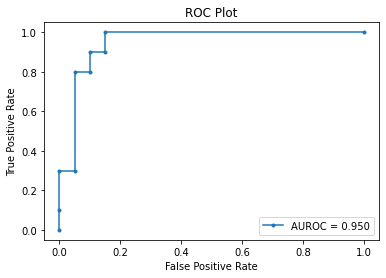

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, recError_lst)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, recError_lst))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [41]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.   0.   0.05 0.05 0.1  0.1  0.15 0.15 1.  ]
The tpr is:  [0.  0.1 0.3 0.3 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [1.016779   0.01677898 0.00882743 0.00742112 0.00645975 0.0064285
 0.00631802 0.00628474 0.00626801 0.00477599]


The best threshold value for this is:0.00626801 , let's asses this.

In [42]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [43]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [44]:
best_threshold_approach1 =0.00626801

In [45]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(recError_lst, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[17  3]
 [ 0 10]]
The FPR values are:  0.15
The TPR values are:  1.0
Using the threshold =  0.00626801


# Validating the performance of the model with the mapping of the reconstruction error to a probability value

In [46]:
probs_list = map_error2prob_list(recError_lst)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [30.584442380783155, 42.05832414199327, 39.91670610196547, 0.13705684391171158, 23.47821176724765, 28.35353995997752, 45.52425214612932, 33.70493558082824, 31.215673132418924, 5.914783337046696, 35.71011055591393, 34.86305465926777, 52.527777078751726, 36.199558365572074, 12.231080416706817, 28.43173540070458, 7.073659409548723, 60.37389778084121, 59.49562099394139, 55.84281775286109, 13.603981215908414, 19.099042034243546, 100, 5.179926236043434, 7.377091272820047, 100, 100, 16.945844030989292, 17.951398116885205, 42.11112959267786]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [47]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, probs_list))

AUC =  0.47500000000000003


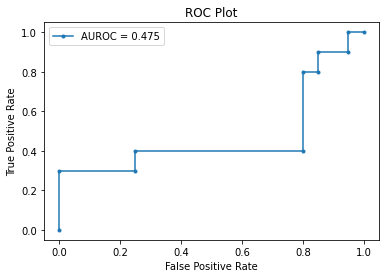

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, probs_list)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, probs_list))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [49]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.   0.25 0.25 0.8  0.8  0.85 0.85 0.95 0.95 1.  ]
The tpr is:  [0.  0.3 0.3 0.4 0.4 0.8 0.8 0.9 0.9 1.  1. ]
The thresholds are:  [101.         100.          45.52425215  42.11112959  23.47821177
  13.60398122  12.23108042   7.37709127   5.91478334   5.17992624
   0.13705684]


The best threshold in terms of FPR and TPR is 5.17992624. Let's asses that.

In [50]:
best_threshold_approach2 = 5.17992624

In [51]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list,  best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold =  ", best_threshold_approach2)

[[ 1 19]
 [ 1  9]]
The FPR values are:  0.95
The TPR values are:  0.9
Using the threshold =   5.17992624


But this threshold is still being a bad results because of the FPR that it represents; this is too high.

# Evaluating the model. With the threhsold value of the direct reconstruction error

In [52]:
test_dir = '../../Images/june5Night/Evaluation'      #This is for the home laptop
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
# test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the work laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_test = datasets.ImageFolder(test_dir, transform=transform_characteristics)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=15, shuffle=True)
classes = ('non-anomaly','anomaly')

In [53]:
y_true = []
recError_lst = []

for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    imgs_croped = transforms.functional.crop(image_in_tensor.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
    image_in_tensor = imgs_croped[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = mse(image_in_tensor[0], Y[0])
    recError_lst.append(err)     # idx of data item, err
    y_true.append(ground_truth) # Save Truth
print("The reconstruction error list is: ", recError_lst)
print("The ground truth labels are: ", y_true)

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The reconstruction error list is:  [0.0049897353, 0.006243876, 0.00605196, 0.0065725655, 0.00559623, 0.0054373294, 0.0055406857, 0.0075309086, 0.0081769, 0.007005883, 0.008808568, 0.007529542, 0.0077134045, 0.005888048, 0.0067896643, 0.0049970774, 0.007412104, 0.004891492, 0.0049380823, 0.0049643926, 0.0066163507, 0.006485114, 0.008841762, 0.008625633, 0.006304497, 0.011286544, 0.009003828, 0.0076321675, 0.006457107, 0.0065490096]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [54]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(recError_lst, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[11  9]
 [ 0 10]]
The FPR values are:  0.45
The TPR values are:  1.0
Using the threshold =  0.00626801


In [55]:
def computePredList(probs_list, threshold_value):
    pred = 0
    pred_list =[]
    for i in range (len(probs_list)):
        if probs_list[i] > threshold_value:              # Working with a threshold of 50%
            pred = 1
        else:
            pred = 0
        pred_list.append(pred)
    return pred_list

In [56]:
y_pred = computePredList(recError_lst, best_threshold_approach1)
print("The groudn truth is: ", y_true)
print("The predicted label is: ", y_pred)

The groudn truth is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The predicted label is:  [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [57]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [58]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[11  9]
 [ 0 10]]


Text(0.5, 15.0, 'Predicted label')

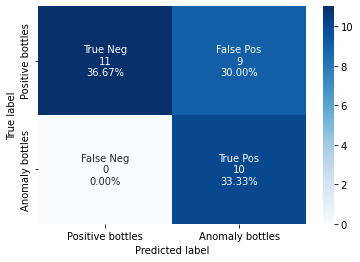

In [59]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [60]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.45
The TPR values are:  1.0


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [61]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.5263157894736842


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [62]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  1.0


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [63]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.55


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [64]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.7


## The ROC curve

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [66]:
auc_score = roc_auc_score(y_true, recError_lst)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, recError_lst)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.760
The fpr is:  [0.   0.   0.   0.05 0.05 0.15 0.15 0.4  0.4  0.45 0.45 1.  ]
The tpr is:  [0.  0.1 0.3 0.3 0.4 0.4 0.5 0.5 0.6 0.6 1.  1. ]
The thresholds are:  [1.0112865  0.01128654 0.00884176 0.00880857 0.00862563 0.0077134
 0.00763217 0.00678966 0.00661635 0.00657257 0.0063045  0.00489149]


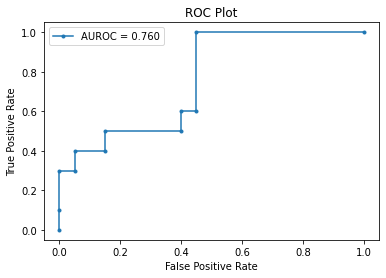

In [67]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Evaluating the model. With the threhsold value computed from a probability value upon the reconstruction errors

In [68]:
probs_list = map_error2prob_list(recError_lst)
print("The probability list is: ", probs_list)
print("The ground truth labels are: ", y_true)

The probability list is:  [50.98256806348439, 4.119377554471349, 4.312656551998434, 18.560676040708277, 24.335620069181076, 31.31706941819687, 26.776005252311236, 60.66644529705163, 89.04875103140441, 37.598913038363435, 100, 60.606397254525746, 68.68458778502105, 11.514288876708786, 28.099128577078258, 50.65998629636154, 55.44664388728317, 55.298989126496366, 53.25199534428192, 52.096024492236005, 20.48442300582701, 14.718399231712404, 100, 100, 6.782810015154203, 100, 100, 65.1153607803013, 13.487895153458041, 17.525721942168516]
The ground truth labels are:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [69]:
conf_matrix = confusion_matrix(y_true, pred_label_onProb(probs_list, best_threshold_approach2))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach2)

[[ 2 18]
 [ 0 10]]
The FPR values are:  0.9
The TPR values are:  1.0
Using the threshold =  5.17992624


In [70]:
y_pred = computePredList(probs_list, best_threshold_approach2)
print("The groudn truth is: ", y_true)
print("The predicted label is: ", y_pred)

The groudn truth is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The predicted label is:  [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [71]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [72]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 2 18]
 [ 0 10]]


Text(0.5, 15.0, 'Predicted label')

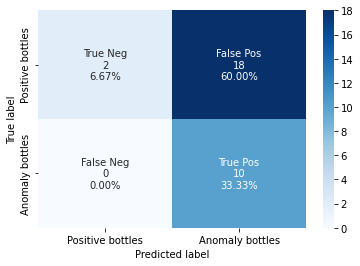

In [73]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [74]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.9
The TPR values are:  1.0


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [75]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.35714285714285715


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [76]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  1.0


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [77]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.1


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [78]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.4


## The ROC curve

In [79]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [80]:
auc_score = roc_auc_score(y_true, probs_list)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, probs_list)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.550
The fpr is:  [0.   0.05 0.15 0.15 0.8  0.8  0.85 0.85 0.9  0.9  1.  ]
The tpr is:  [0.  0.4 0.4 0.5 0.5 0.6 0.6 0.9 0.9 1.  1. ]
The thresholds are:  [101.         100.          68.68458779  65.11536078  24.33562007
  20.48442301  18.56067604  13.48789515  11.51428888   6.78281002
   4.11937755]


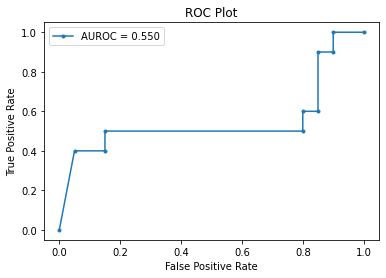

In [81]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()